
# Autómatas Celulares en 2D 

## ¿Qué es un autómata celular 2D?
Un **autómata celular** es un modelo discreto que consiste en:
- Una **rejilla** (matriz) de celdas.
- Un **conjunto finito de estados** por celda (por ejemplo, 0/1 para muerto/vivo).
- Una **regla local** que actualiza cada celda **en paralelo**, usando el estado de la celda y el de sus **vecinas**.
- El tiempo avanza en **pasos discretos**: $t = 0,1,2,\dots$

En 2D solemos usar la **vecindad de Moore** (8 vecinas alrededor) o vecindades **extendidas** (radio $r>1$).



## Juego de la Vida y variantes
En este notebook se incluyen funciones para simular:
- El **Juego de la Vida de Conway** (binario, con vecindad de Moore).
- Variantes con **vecindad de radio 2** (o general $r$).
- Otros AC como el **bosque en llamas** (estocástico, con estados 0=vacío, 1=árbol, 2=fuego).


## Arquitectura general del código
1. **Generación de vecinos**: una función como `vecinos8` o `vecinos(x, r)` que **cuenta vecinos** por celda.
2. **Regla**: una función como `regla_vida(x)` que, usando el conteo de vecinos, **decide el siguiente estado**.
3. **Evolución**: una función `evolucion(estado_inicial, pasos, regla)` que **itera la regla** y guarda la trayectoria.
4. **Visualización**: funciones para **ver la evolución** con *slider*, *play/pausa*, o *animación continua*.



## Funciones clave

### 1) Conteo de vecinos (`vecinos8` o `vecinos(x, r)`)
- Entrada: un arreglo binario (o entero) `x` de tamaño $N\times M$ con el **estado actual**.
- Salida: otro arreglo de tamaño $N\times M$ donde cada entrada es el **número de vecinas** (excluyendo la celda central).
- Usualmente usamos **condiciones periódicas** (índices con módulo) para que el borde “se conecte” al otro lado.

**Vecindad de Moore**

En un autómata celular bidimensional, cada celda $(i,j)$ tiene vecinos definidos por su posición relativa.
La vecindad de Moore son las 8 celdas alrededor de la central:
```
(i-1,j-1)   (i-1,j)   (i-1,j+1)
(i,  j-1)   (i,  j)   (i,  j+1)
(i+1,j-1)   (i+1,j)   (i+1,j+1)
```
La celda central $(i,j)$ no se cuenta.

**Conteo de vecinos: `vecinos8`**

Esta función calcula, para **cada celda**, el **número de vecinas vivas** en la **vecindad de Moore** (8 posiciones alrededor).
Se implementa con **índices modulares** para imponer **condiciones periódicas** (el tablero “se envuelve”).


### 2) Regla del Juego de la Vida (`regla_vida`)
- **Sobrevive** si está viva y tiene **2 o 3** vecinas vivas.
- **Nace** si está muerta y tiene **exactamente 3** vecinas vivas.
- Cualquier otro caso: **muere** o **permanece muerta**.

En código vectorizado (con `numpy`), esto se escribe como **operaciones lógicas** sobre arreglos:
- `x == 1` para identificar celdas vivas;
- `n == 2`, `n == 3` para contar vecinas;
- combinaciones con `&` (y) y `|` (o) para sintetizar la regla.



### 3) Evolución temporal (`evolucion`)
- Aplica la **regla** paso a paso, guardando cada **frame** en una matriz 3D de forma `(pasos+1, N, M)`.
- Devuelve toda la **trayectoria**, útil para *sliders* y *animaciones*.



### 4) Visualización (`ver_con_slider`, `ver_con_slider_play`, `animar_automata`, editor interactivo)
- **Slider**: permite inspeccionar cualquier tiempo `t` de la trayectoria.
- **Play/Pausa**: reproduce automáticamente avanzando el slider.
- **Animación continua**: dibuja en vivo con `FuncAnimation`.
- **Editor clickeable** (si está incluido): permite *pintar* celdas y luego correr/pausar la evolución.


In [9]:
import numpy as np
%matplotlib widget
def vecinos8(x: np.ndarray) -> np.ndarray:
    """
    Suma de vecinos (Moore) con condiciones periódicas,
    usando índices con módulo.
    """
    N, M = x.shape
    n = np.zeros_like(x, dtype=int)
    for i in range(N):
        for j in range(M):
            s = 0
            for di in (-1, 0, 1):
                for dj in (-1, 0, 1):
                    if di == 0 and dj == 0:
                        continue
                    s += x[(i + di) % N, (j + dj) % M]
            n[i, j] = s
    return n

def regla_vida(x: np.ndarray) -> np.ndarray:
    """
    Conway Life: nace con 3, sobrevive con 2 o 3.
    x es binaria (0/1).
    """
    n = vecinos8(x)
    return ((x == 1) & ((n == 2) | (n == 3))) | ((x == 0) & (n == 3))

def evolucion(estado_inicial: np.ndarray, pasos: int, regla) -> np.ndarray:
    """
    Devuelve un arreglo (pasos+1, N, M) con la trayectoria completa.
    """
    x = estado_inicial.astype(np.uint8)
    T = np.zeros((pasos+1, *x.shape), dtype=np.uint8)
    T[0] = x
    for t in range(pasos):
        x = regla(x).astype(np.uint8)
        T[t+1] = x
    return T


### Ejemplo de estado inicial y vecinos

In [10]:
x = np.zeros((5,5), dtype=int)
x[2,2] = 1
print("Estado inicial:")
print(x)
print("Vecinos:")
print(vecinos8(x))

Estado inicial:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Vecinos:
[[0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]]


# Ejemplos de implementación

## Visualización con slider: `ver_con_slider(...)`

Permite **navegar** por los tiempos de la trayectoria con un **control deslizante**.

interactive(children=(IntSlider(value=0, description='t', max=200), Output()), _dom_classes=('widget-interact'…

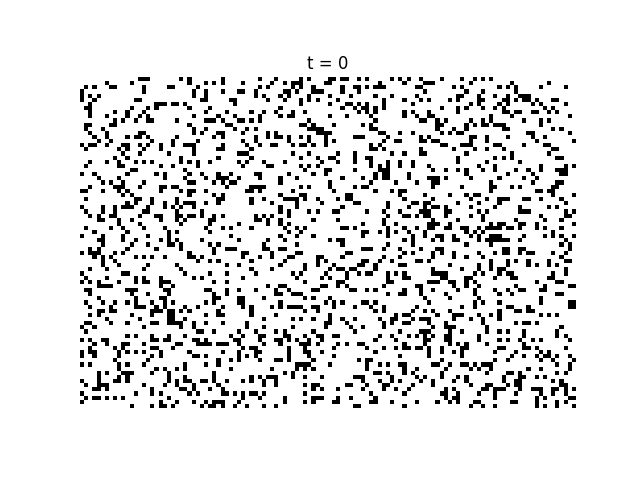

In [11]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def ver_con_slider(trayectoria: np.ndarray, cmap='binary'):
    """
    Muestra un frame con slider de tiempo.
    """
    pasos, n, m = trayectoria.shape[0]-1, *trayectoria.shape[1:]
    fig, ax = plt.subplots()
    im = ax.imshow(trayectoria[0], cmap=cmap, interpolation='nearest')
    ax.set_title("t = 0"); ax.set_axis_off()

    def actualizar(t=0):
        im.set_data(trayectoria[t])
        ax.set_title(f"t = {t}")

    interact(actualizar, t=IntSlider(min=0, max=pasos, value=0, step=1));

# Ejemplo de uso:
np.random.seed(0)
x0 = (np.random.rand(80, 120) < 0.2).astype(np.uint8)
T = evolucion(x0, pasos=200, regla=regla_vida)
ver_con_slider(T)


## Slider con botón Play/Pausa: `ver_con_slider_play(...)`

Extiende el slider con un **botón de reproducción** que avanza el tiempo automáticamente. Puedes ajustar la velocidad con una pausa entre frames.


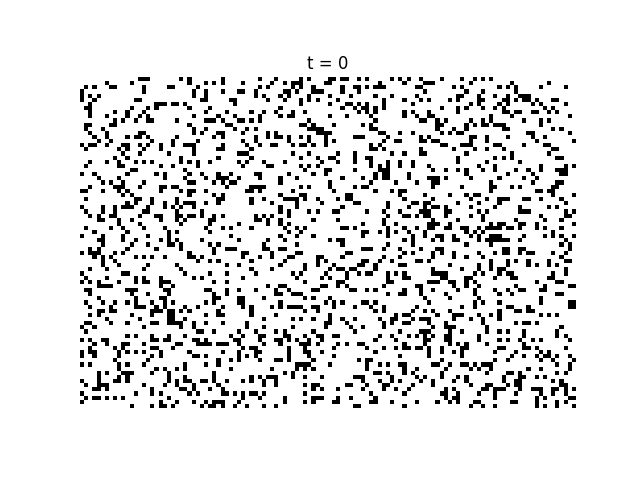

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import threading
from ipywidgets import IntSlider, Button, HBox, VBox, Output

def ver_con_slider_play(trayectoria: np.ndarray, cmap='binary'):
    """
    Visualiza la evolución con un slider y un botón Play/Pausa.
    """
    pasos, n, m = trayectoria.shape[0]-1, *trayectoria.shape[1:]
    fig, ax = plt.subplots()
    im = ax.imshow(trayectoria[0], cmap=cmap, interpolation='nearest')
    ax.set_title("t = 0")
    ax.set_axis_off()

    # --- Widgets ---
    slider = IntSlider(min=0, max=pasos, value=0, step=1, description='t')
    boton = Button(description='▶ Play', button_style='success')
    out = Output()

    # --- Estado ---
    estado = {'reproduciendo': False}

    # --- Función de actualización ---
    def actualizar(change=None):
        t = slider.value
        im.set_data(trayectoria[t])
        ax.set_title(f"t = {t}")
        fig.canvas.draw_idle()

    slider.observe(actualizar, names='value')

    # --- Reproducción automática ---
    def reproducir():
        while estado['reproduciendo']:
            time.sleep(0.1)  # velocidad (en segundos)
            if slider.value < pasos:
                slider.value += 1
            else:
                estado['reproduciendo'] = False
                boton.description = '▶ Play'
                boton.button_style = 'success'
                break

    def on_click(b):
        if not estado['reproduciendo']:
            estado['reproduciendo'] = True
            boton.description = '⏸ Pause'
            boton.button_style = 'warning'
            threading.Thread(target=reproducir, daemon=True).start()
        else:
            estado['reproduciendo'] = False
            boton.description = '▶ Play'
            boton.button_style = 'success'

    boton.on_click(on_click)

    display(VBox([HBox([boton, slider]), out]))
    actualizar()

# Ejemplo de uso:
np.random.seed(0)
x0 = (np.random.rand(80, 120) < 0.2).astype(np.uint8)
T = evolucion(x0, pasos=200, regla=regla_vida)
ver_con_slider_play(T)



## Animación continua: `animar_automata(...)`

Usa `matplotlib.animation.FuncAnimation` para reproducir la dinámica en vivo. Útil para presentaciones y para exportar a video/GIF.


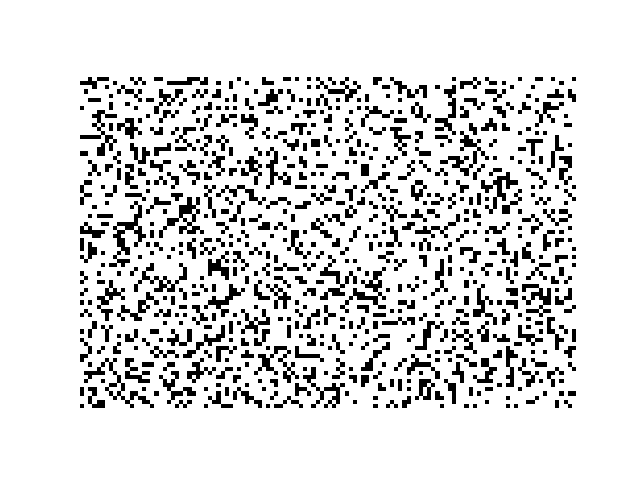

In [5]:
from matplotlib.animation import FuncAnimation

def animar_automata(x0: np.ndarray, pasos: int = 300, intervalo_ms: int = 60, cmap='binary'):
    fig, ax = plt.subplots()
    im = ax.imshow(x0, cmap=cmap, interpolation='nearest')
    ax.set_axis_off()

    x = x0.copy().astype(np.uint8)

    def paso(_):
        nonlocal x
        x = regla_vida(x).astype(np.uint8)
        im.set_data(x)
        return (im,)

    ani = FuncAnimation(fig, paso, frames=pasos, interval=intervalo_ms, blit=True)
    plt.show()
    return ani

# Ejemplo:
np.random.seed(1)
x0 = (np.random.rand(80, 120) < 0.25).astype(np.uint8)
ani = animar_automata(x0, pasos=400, intervalo_ms=50)


## Visualización controlada por teclado: `visor_teclado(...)`

Esta función permite **explorar manualmente** la evolución del autómata celular utilizando el **teclado** en lugar de un control deslizante o animación automática. Es ideal para analizar **paso a paso** la evolución del *Juego de la Vida* y observar transiciones locales con precisión.

### Controles disponibles

| Tecla | Acción |
|:------|:--------|
| **Barra espaciadora (␣)** | Avanza **un paso temporal** aplicando la regla (`regla_vida`). |
| **r** | Genera un **estado aleatorio** nuevo (reinicia la simulación con valores 0/1 aleatorios). |


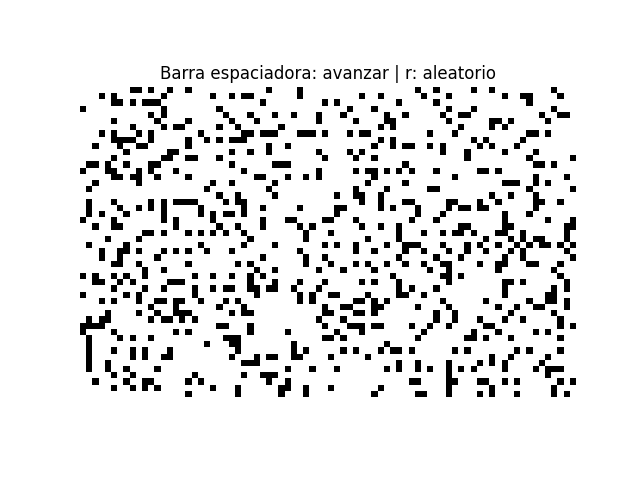

In [6]:
def visor_teclado(x0: np.ndarray, cmap='binary'):
    x = x0.copy().astype(np.uint8)
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap=cmap, interpolation='nearest')
    ax.set_title("Barra espaciadora: avanzar | r: aleatorio")
    ax.set_axis_off()

    def on_key(event):
        nonlocal x
        if event.key == ' ':
            x = regla_vida(x).astype(np.uint8)
            im.set_data(x)
            fig.canvas.draw_idle()
        elif event.key == 'r':
            x = (np.random.rand(*x.shape) < 0.25).astype(np.uint8)
            im.set_data(x)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect('key_press_event', on_key)
    plt.show()

# Ejemplo:
visor_teclado((np.random.rand(50, 80) < 0.2).astype(np.uint8))


## Ejercicios
- **Densidad inicial**: cambia la probabilidad de celdas vivas en el estado inicial y observa el régimen (extinción/estabilidad/caos).
- **Fronteras**: compara condiciones periódicas (toro) con fronteras fijas (cero en bordes).
- **Radio de vecindad**: prueba `r=1,2,3` y ajusta **umbrales** de nacimiento/supervivencia.
- **Mediciones**: grafica la **densidad de celdas vivas** a lo largo del tiempo.


## Ejercicios 

### 1) Densidad inicial y regímenes dinámicos

**Objetivo.** Observar cómo la **densidad inicial** de celdas vivas (probabilidad de que `x0[i,j]=1`) influye en la dinámica: extinción, configuraciones estables/oscilantes o “caos”.

**Qué debes hacer.**
1. Genera varios estados iniciales `x0` variando la probabilidad `p` en un rango p.ej. `p ∈ {0.05, 0.1, 0.2, 0.3, 0.5}`.
2. Para cada `p`, simula `T = evolucion(x0, pasos, regla_vida)` con un número de pasos fijo (por ejemplo, 200).
3. Observa con el *slider* o *play* si el sistema:
   - **Se extingue** (todo cero).
   - **Se estabiliza** en patrones estáticos u osciladores.
   - Muestra comportamiento **activo/caótico** por largo tiempo.
4. Registra la **densidad viva** por tiempo: `dens[t] = T[t].mean()` y grafícala.

**Entregables.**
- Una tabla o lista con `p` y una breve **clasificación** del régimen observado.
- Una **gráfica** de densidad viva vs. tiempo para al menos 3 valores de `p`.

**Pistas.**
- Usa `np.random.rand(N,M) < p` para crear `x0`.
- Para la densidad: `dens = T.reshape(T.shape[0], -1).mean(axis=1)`.




### 2) Condiciones de frontera: toro vs. bordes fijos

**Objetivo.** Comparar el efecto de las **condiciones periódicas** (toro) frente a **bordes fijos** (celdas fuera de la rejilla se consideran 0).

**Qué debes hacer.**
1. Implementa una variante de la función de conteo de vecinas que **no use módulo** y trate índices fuera de rango como 0 (bordes fijos).
2. Simula el mismo `x0` y mismos parámetros con ambas fronteras:
   - **Periódicas** (versión actual con índices modulares).
   - **Fijas** (nueva versión).
3. Compara visualmente y cuantitativamente (por ejemplo, densidad viva a lo largo del tiempo).

**Entregables.**
- Breve **discusión** de diferencias cualitativas (¿el borde “absorbe” patrones?, ¿hay más extinción?).
- Gráfica comparativa de densidad viva vs. tiempo (dos curvas en la misma figura).

**Pistas.**
- Para bordes fijos, en el doble bucle de vecinos, **omite** las contribuciones que salgan de `[0,N)×[0,M)`.
- Mantén el resto del pipeline (regla y evolución) **idéntico** para una comparación justa.




### 3) Vecindad de radio general y reglas “Larger-than-Life”

**Objetivo.** Generalizar la vecindad a **radio `r` arbitrario**, y permitir **umbrales** de nacimiento/supervivencia adaptados a `r`.

**Qué debes hacer.**
1. **Implementa** la función:
   ```python
   def vecindad(x: np.ndarray, r: int) -> np.ndarray:
       """
       Devuelve, para cada celda, la suma de vecinas en el cuadrado (2r+1)x(2r+1)
       centrado en la celda (excluyendo la celda central), con condiciones periódicas.
       """

### Ejemplo concreto: vecindad de **radio 2** (r = 2)

Con **radio 2**, la vecindad de una celda incluye **todas** las posiciones dentro de un **cuadrado 5×5** centrado en ella, **excluyendo** la celda central.  
En total hay $(2r+1)^2 - 1 = 5^2 - 1 = 24$ vecinas posibles.

#### Offsets incluidos (r = 2)
Los desplazamientos $(\Delta i, \Delta j)$ permitidos son:
$$
\Delta i, \Delta j \in \{-2,-1,0,1,2\}, \quad \text{excepto } (0,0).
$$
Gráficamente (X = celda central, # = vecinas contadas):
```
# # # # # 
# # # # # 
# # X # # 
# # # # # 
# # # # # 
```